The Lecture Codes are modified from the reference below.

Code Reference 1: Al Sweigart, Making Games with Python & Pygame. Createspace Independent Pub, 2012. https://inventwithpython.com/pygame/
Code Reference 2: Penny de Byl, Mathematics for Game Programming and Computer Graphics. Packt Programming, 2022. https://github.com/PacktPublishing/Mathematics-for-Game-Programming-and-Computer-Graphics/ 
Code Reference 3: Paul Orland, Math for Programmers - 3D graphics, machine learning, and simulations with Python. Manning, 2020. https://github.com/orlandpm/Math-for-Programmers

Functions to plot volume or flow rate vs. time with correct labels.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_function(f,tmin,tmax,tlabel=None,xlabel=None,axes=False, **kwargs):
    ts = np.linspace(tmin,tmax,1000)
    if tlabel:
        plt.xlabel(tlabel,fontsize=18)
    if xlabel:
        plt.ylabel(xlabel,fontsize=18)
    plt.plot(ts, [f(t) for t in ts], **kwargs)
    if axes:
        total_t = tmax-tmin
        plt.plot([tmin-total_t/10,tmax+total_t/10],[0,0],c='k',linewidth=1)
        plt.xlim(tmin-total_t/10,tmax+total_t/10)
        xmin, xmax = plt.ylim()
        plt.plot([0,0],[xmin,xmax],c='k',linewidth=1)
        plt.ylim(xmin,xmax)

def plot_volume(f,tmin,tmax,axes=False,**kwargs): # 
    plot_function(f,tmin,tmax,tlabel="time (hr)", xlabel="volume (bbl)", axes=axes, **kwargs)

def plot_flow_rate(f,tmin,tmax,axes=False,**kwargs): # 함수, x의 range(시간에 대한 최소, 최대)
    plot_function(f,tmin,tmax,tlabel="time (hr)", xlabel="flow rate (bbl/hr)", axes=axes, **kwargs)        

# 1 Calculating average flow rates from volumes

These are the *actual* volume and flow rate functions, used throughout the chapter.  
You can ignore the formulas that define them.

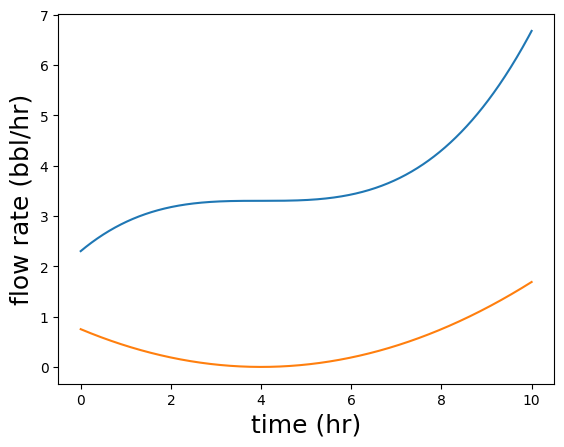

In [29]:
def volume(t):
    return (t-4)**3 / 64 + 3.3

def flow_rate(t):
    return 3*(t-4)**2 / 64

plot_volume(volume,0,10) # 볼륨
plot_flow_rate(flow_rate,0,10) # 변화율

## Implementing an average_flow_rate function


In [7]:
def average_flow_rate(v,t1,t2):
    return (v(t2) - v(t1))/(t2 - t1)

print(volume(4))
print(volume(9))

average_flow_rate(volume,4,9)

3.3
5.253125


0.390625

## **Exercise:**: Picturing the average flow rate with a secant line

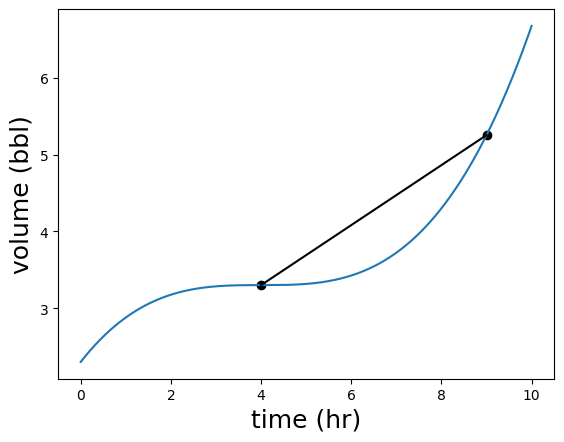

In [15]:
def secant_line(f,x1,x2):
    def line(x):
        ########
        return (x- x1)*(f(x2) - f(x1))/(x2 - x1) + f(x1)
        ########
    return line

def plot_secant(f,x1,x2,color='k'):
    line = secant_line(f,x1,x2)
    plot_function(line,x1,x2,c=color)
    plt.scatter([x1,x2],[f(x1),f(x2)],c=color)

plot_volume(volume, 0, 10)
plot_secant(volume, 4, 9)

# 2 Plotting the average flow rate over time

## Finding the average flow rate in different time intervals

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5
 9.  9.5]
[(0, 0.578125), (1, 0.296875), (2, 0.109375), (3, 0.015625), (4, 0.015625), (5, 0.109375), (6, 0.296875), (7, 0.578125), (8, 0.953125), (9, 1.421875)]


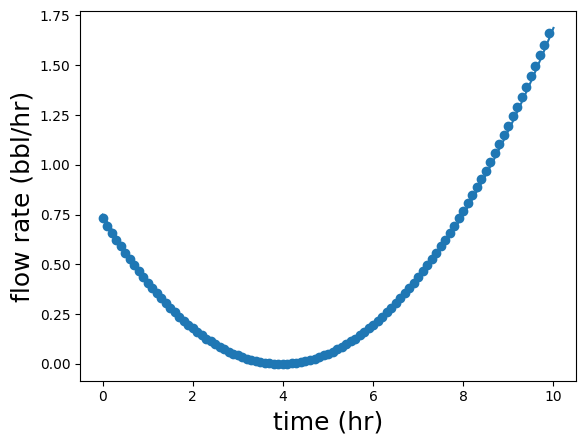

In [25]:
import numpy as np

print(np.arange(0,10,0.5))


def interval_flow_rates(v,t1,t2,dt):
    return [(t,average_flow_rate(v,t,t+dt))
                for t in np.arange(t1,t2,dt)]

print(interval_flow_rates(volume,0,10,1))


def plot_interval_flow_rates(volume,t1,t2,dt):
    series = interval_flow_rates(volume,t1,t2,dt)
    times = [t for (t,_) in series]
    rates = [q for (_,q) in series]
    plt.scatter(times,rates)

plot_flow_rate(flow_rate,0,10)
plot_interval_flow_rates(volume,0,10,0.1) # See how it changes when we shorten the interval

## **Exercise:**: Emprically find the time inverval which is good enough to represent the original flow rate

# 3 Approximating instantaneous flow rates

## Finding the slope of very small secant lines. 

These calculations result in numbers converging (getting closer and closer) to a value of `0.421875`

In [26]:
average_flow_rate(volume,0.5,1.5)

0.578125

In [54]:
average_flow_rate(volume,0.9,1.1)

0.4220312499999988

In [55]:
average_flow_rate(volume,0.99,1.01)

0.42187656249998945

In [56]:
average_flow_rate(volume,0.999,1.001)

0.42187501562509583

In [57]:
average_flow_rate(volume,0.9999,1.0001)

0.42187500015393936

In [58]:
average_flow_rate(volume,0.99999,1.00001)

0.4218750000002602

Compare to actual value from flow rate function

In [9]:
flow_rate(1)

0.421875

Compute the instantaneous flow rate at any point in time. That is, we can find a tangent line to the graph of a function at a point, its slope is called the derivative of the function at the point.

In [17]:
def instantaneous_flow_rate(v,t,digits=6): 
    tolerance = 10 ** (-digits) #<1> digits 에러에 대한 정밀도
    h = 1
    approx = average_flow_rate(v,t-h,t+h) #<2> 대략적인 유량
    for i in range(0,2*digits): #<3> 시간 간격을 줄이면서 최대 반복 횟수 지정
        h = h / 10
        next_approx = average_flow_rate(v,t-h,t+h) #<4> 어림셈을 계산해 보다
        if abs(next_approx - approx) < tolerance:
            return round(next_approx,digits) #<5> 리턴
        else:
            approx = next_approx #<6> 반복
    raise Exception("Derivative did not converge") #<7> 에러 메세지

print(instantaneous_flow_rate(volume,1))


0.421875


Building the instantaneous flow rate function.

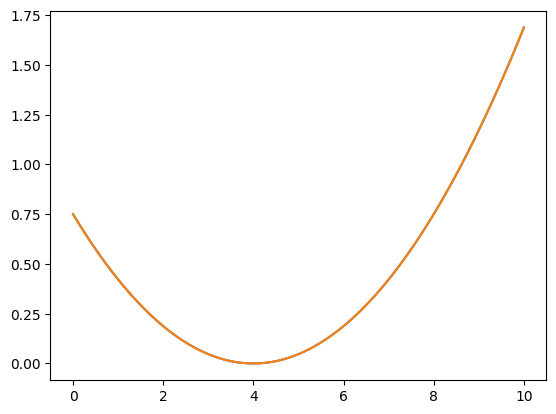

In [18]:
def get_flow_rate_function(v):
    def flow_rate_function(t):
        return instantaneous_flow_rate(v,t)
    return flow_rate_function

plot_function(flow_rate,0,10)
plot_function(get_flow_rate_function(volume),0,10)

## **Self Study:** For the sign function defined in Python below, convince yourself that it doesn’t have a derivative at $x=0$.

In [20]:
def sign(x):
    return x / abs(x)

for i in range(1,10):
    print(average_flow_rate(sign,-10**-i, 10**-i))

print(instantaneous_flow_rate(sign,0)) # 그 지점에서 미분을 할 수 없는 함수였다


10.0
100.0
1000.0
10000.0
99999.99999999999
1000000.0
10000000.0
100000000.0
999999999.9999999


Exception: Derivative did not converge

# 4 Approximating the change in volume

## Finding the change in volume on a short time interval

In [32]:
def small_volume_change(q,t,dt):
    return q(t) * dt

t = 2
dt= 0.01

print(small_volume_change(flow_rate,t,dt))
print(volume(t+dt) - volume(t))

0.001875
0.0018656406250001645


## Breaking up time into small intervals

In [33]:
def volume_change(q,t1,t2,dt):
    return sum(small_volume_change(q,t,dt)
               for t in np.arange(t1,t2,dt))

print(volume_change(flow_rate,0,10,0.1))
print(volume(10) - volume(0))          

print(volume_change(flow_rate,0,10,0.0001))

4.32890625
4.375
4.3749531257812455


## **Self Study:** Approximately how much oil is added to the tank in the first 6 hours?  In the last 4 hours?  During which time interval is more added?

In [34]:
print(volume_change(flow_rate,0,6,0.01))

print(volume_change(flow_rate,6,10,0.01))

1.1278171874999996
3.2425031249999257


## Finding the volume over time

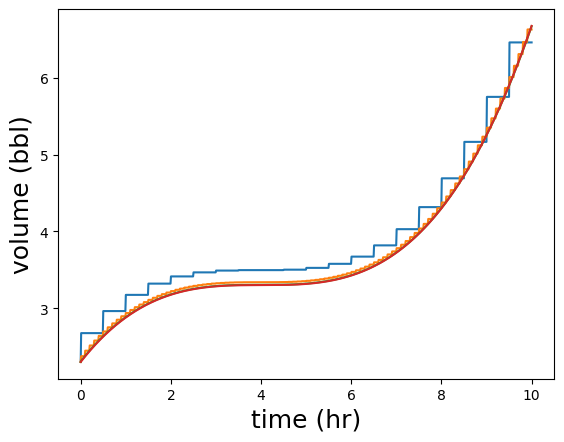

In [35]:
def approximate_volume(q,v0,dt,T):
    return v0 + volume_change(q,0,T,dt)

def approximate_volume_function(q,v0,dt):
    def volume_function(T):
        return approximate_volume(q,v0,dt,T)
    return volume_function    

plot_volume(approximate_volume_function(flow_rate,2.3,0.5),0,10)
plot_volume(approximate_volume_function(flow_rate,2.3,0.1),0,10)
plot_volume(approximate_volume_function(flow_rate,2.3,0.01),0,10)
plot_volume(volume,0,10)    

## **Self Study:** Check what happens if you increase the duration of integration.

In [37]:
def get_volume_function(q,v0,digits=6):
    def volume_function(T):
        tolerance = 10 ** (-digits)
        dt = 1
        approx = v0 + volume_change(q,0,T,dt)
        for i in range(0,digits*2):
            dt = dt / 10
            next_approx = v0 + volume_change(q,0,T,dt)
            if abs(next_approx - approx) < tolerance:  # 여기서 approx를 Ground Truth를 안다면 이로 대체해도 된다.
                return round(next_approx,digits)
            else:
                approx = next_approx
        raise Exception("Did not converge!")
    return volume_function

v = get_volume_function(flow_rate,2.3,digits=3) 
print(v(10)-v(0))

v = get_volume_function(flow_rate,2.3,digits=6)
print(v(10)-v(0)) # Check how long it takes as t increases compare t=1, t=10

4.375
4.375
